In [1]:
# importing required libraries
import matplotlib
import pandas as pd
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
import numpy as np
import sys
from IPython.display import display
import warnings
import matplotlib.pyplot as plt
import datetime
import pycountry_convert as pc
import pycountry
import folium
from folium.plugins import MarkerCluster
from geopy.geocoders import Nominatim
import math
from sklearn import preprocessing

# library options
%matplotlib inline
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

In [2]:
def sorting(df, key):
    return df.sort_values(by=key)
def res_index(df):
    return df.reset_index(drop = True)
def copy_df(df):
    return df.copy()
def fillZero(df, values):
    return df.fillna(value=values)
def filterBuyer(df, column):
    return df.loc[df[column] > 0 ]
def filterNoBuyer(df, column):
    return df.loc[df[column] == 0]
def drop_col(df,column):
    return df.drop(labels=column,axis=1,errors = "ignore")
def replace_minus(df, column):
    df[column] = df[column].str.replace('-', " ")
    return df

# Data Input

In [3]:
# load datasets
df1_test = pd.read_parquet('data/ml_dataset_test.parquet', engine='pyarrow')
df1_train = pd.read_parquet('data/ml_dataset_train.parquet', engine='pyarrow')
df1_ext = pd.read_parquet('data/ml_payers_extension.parquet', engine='pyarrow')


In [4]:
df1_test.set_index('account_id', inplace=True)
df1_train.set_index('account_id', inplace=True)
df1_ext.drop_duplicates(subset=['account_id'], inplace=True)
df1_ext.set_index('account_id', inplace=True)

In [5]:
df_1 = pd.concat([df1_test, df1_train, df1_ext])
df_2 = pd.read_parquet('data/transactional_dataset_v2.parquet', engine='pyarrow')

In [6]:
df_1.reset_index(inplace=True)

In [7]:
df_1.account_id.nunique()

3416914

In [8]:
df_1.index.nunique()

3416914

In [9]:
print(df_2.shape)
print(df_2[df_2['account_id'].isin(df_1.account_id.unique())].shape) # account_ids which are in both
print(df_2[~df_2['account_id'].isin(df_1.account_id.unique())].shape) # account_ids which are NOT in df1

(435412, 5)
(322107, 5)
(113305, 5)


In [10]:
df_1

,account_id,n_ad_reward_claims,n_ad_reward_fails,n_ads_watched,n_battlepass_lvls_finished,masked_feature_0,masked_feature_1,masked_feature_2,masked_feature_3,masked_feature_4,masked_feature_5,masked_feature_6,masked_feature_7,masked_feature_8,masked_feature_9,masked_feature_13,masked_feature_14,masked_feature_15,masked_feature_16,masked_feature_17,masked_feature_18,masked_feature_20,masked_feature_21,masked_feature_22,masked_feature_23,masked_feature_24,masked_feature_25,masked_feature_26,n_instant_awards_claims,masked_feature_27,masked_feature_28,masked_feature_29,n_extra_challenge_buys,connected_fb,connect_fb_attempt,n_friend_installs,masked_feature_30,masked_feature_31,n_accept_all_friends,n_accept_friend,n_clicked_add_friends,n_friend_searches,masked_feature_32,masked_feature_33,masked_feature_34,masked_feature_35,masked_feature_36,masked_feature_37,masked_feature_38,n_levels_completed,n_calendar_login_days,device_language,n_missions_completed,first_device_os,first_time_zone,first_device_model,first_network_type,first_login_country,first_device_manufacturer,n_package_info_offers_viewed,n_payments_package_key,sum_payments_package_key,n_package_tips_offers_viewed,rated_game,n_remove_ad_clicks,masked_feature_39,n_sessions_ended,total_session_duration,max_session_end_viplevel,max_session_end_player_level,n_sessions_started,min_session_start_viplevel,min_session_start_player_level,is_paid_user,n_time_skip_buys,n_viplevels_completed,bigmac_dollar_price,gdp_per_capita,ram_max,form_factor,screen_density,avg_country_spend_30d,avg_country_spend_30d_first3d,screen_width,screen_height,most_frequent_country,most_frequent_network_type,masked_feature_40,nunique_countries,nunique_network_types,masked_feature_41,nunique_iaps_bought,first_login_weekday,battlepass_0.0,battlepass_22.0,battlepass_23.0,battlepass_8008.0,first_login_day_time,first_login_country_is_mfreq,time_to_first_purchase,time_to_last_purchase,time_between_last_purchase_last_login,sum_payments_package_key_ltv,n_payments_package_key_ltv
0,100000293,<NA>,<NA>,<NA>,2,31,22.0,22,9.0,9,12,9,<NA>,309,<NA>,5.0,24.0,NaN,NaN,NaN,NaN,210.0,20.0,5.0,24.0,NaN,220.0,<NA>,<NA>,17,24,1,<NA>,2,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,<NA>,11,220.0,<NA>,<NA>,<NA>,7,en,87,android,+05:30,POCO F1,WIFI,IN,Xiaomi,205,<NA>,NaN,17,<NA>,<NA>,32,31,10301955.0,<NA>,7,31,<NA>,0,False,<NA>,<NA>,2.588909,1900.706810,NaN,None,NaN,16.751835,8.488506,NaN,NaN,IN,WIFI,None,1.0,2.0,NaN,NaN,Saturday,False,False,False,False,morning,1,NaN,NaN,NaN,NaN,<NA>
1,100000333,<NA>,<NA>,5,2,31,20.0,20,11.0,11,17,11,<NA>,307,<NA>,11.0,24.0,NaN,NaN,NaN,NaN,200.0,NaN,10.0,21.0,NaN,50.0,<NA>,<NA>,5,24,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,4,178238.0,<NA>,4,20.0,<NA>,1,<NA>,4,ru,91,android,+03:00,Mi A3,WIFI,RU,Xiaomi,51,<NA>,NaN,19,<NA>,<NA>,34,13,8417646.0,<NA>,7,14,<NA>,0,False,<NA>,<NA>,1.808924,10126.721794,3613.0,Phone,320.0,23.861452,5.945218,720.0,1560.0,RU,WIFI,None,1.0,1.0,NaN,NaN,Saturday,False,False,False,False,morning,1,NaN,NaN,NaN,NaN,<NA>
2,100000463,<NA>,<NA>,<NA>,<NA>,2,NaN,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,1,en,5,android,+07:00,SM-A515F,WIFI,HK,samsung,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,1,44970.0,<NA>,1,2,<NA>,0,False,<NA>,<NA>,2.643337,46323.863442,5576.0,Phone,NaN,57.015214,38.927471,1080.0,2009.0,HK,NULL,None,1.0,2.0,NaN,NaN,Saturday,False,False,False,False,morning,1,NaN,NaN,NaN,NaN,<NA>
3,100000624,<NA>,<NA>,<NA>,<NA>,6,NaN,<NA>,NaN,<NA>,2,<NA>,<NA>,<NA>,<NA>,NaN,3.0,NaN,NaN,NaN,NaN,30.0,NaN,NaN,1.0,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,2,de,19,android,+01:00,AGS2-W09,WIFI,AT,HUAWEI,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,1,4,2525386.0,<NA>,1,4,<NA>,0,False,<NA>,<NA>,NaN,48105.364625,NaN,None,NaN,41.824738,16.015051,NaN,NaN,AT,WIFI,None,1.0,1.0,NaN,NaN,

In [11]:
df_1.to_parquet('data/df1.parquet')
df_2.to_parquet('data/df2.parquet')

# Data Cleaning

In [12]:
##### INITALIZE DF
df = pd.read_parquet('data/df1.parquet', engine='pyarrow')

# setting "account_id" as index
df = df.set_index(keys = "account_id")

## Missing Values (Rows)

In [13]:
# represents how many missing values are in one rows
rows_missing = df.isnull().sum(axis=1)

# dropping all rows with < "threshhold" missing values (104 columns)
threshhold = np.percentile(rows_missing, 97) # using 97 percentile for threshhold defining

rows_drop = df[rows_missing >= threshhold].index
df = df.drop(rows_drop)

#### Dropping Rows where the features "is_paid_user" and "sum_payments_package_key" are conflicting

In [14]:
# logical there should not be any values satisfying both conditions at the same time
conflicts = df[(df["is_paid_user"] == True) & (df["sum_payments_package_key"].isnull()) ]
print("n_errors to drop", len(conflicts))

# dropping error containing 
df = df.drop(conflicts.index   )

n_errors to drop 6870


#### Dropping rows where AVG features is NaN

In [15]:
idx_drop = df[df["avg_country_spend_30d"].isnull()].index
df = df.drop(idx_drop)

idx_drop = df[df["avg_country_spend_30d_first3d"].isnull()].index
df = df.drop(idx_drop)

## Missing Values (Columns)

##### Dropping Feature (too many missing values, not interpretable, redundant)

In [16]:
features_drop =[
"masked_feature_9",
"masked_feature_16",
"masked_feature_17",
"nunique_countries",
"masked_feature_18",
"masked_feature_26",
"masked_feature_33",
"masked_feature_34",
"n_calendar_login_days",
"max_session_end_viplevel",
"min_session_start_viplevel",
"is_paid_user",
"masked_feature_40",
"time_to_first_purchase",
"time_to_last_purchase"]

df = df.drop(features_drop, axis =1, errors='ignore')
print("Dropping", len(features_drop),"features")

Dropping 15 features


##### Filling missing values with zeros

In [17]:
features_zero =[
"n_ad_reward_claims",
"n_ad_reward_fails",
"n_ads_watched",
"n_battlepass_lvls_finished",
"masked_feature_0",
"masked_feature_1",
"masked_feature_2",
"masked_feature_3",
"masked_feature_4",
"masked_feature_5",
"masked_feature_6",
"masked_feature_7",
"masked_feature_8",
"masked_feature_13",
"masked_feature_14",
"masked_feature_15",
"masked_feature_20",
"masked_feature_21",
"masked_feature_22",
"masked_feature_23",
"masked_feature_24",
"masked_feature_25",
"n_instant_awards_claims",
"masked_feature_27",
"masked_feature_28",
"masked_feature_29",
"n_extra_challenge_buys",
"connected_fb",
"connect_fb_attempt",
"n_friend_installs",
"masked_feature_30",
"masked_feature_31",
"n_accept_all_friends",
"n_accept_friend",
"n_clicked_add_friends",
"n_friend_searches",
"masked_feature_32",
"masked_feature_35",
"masked_feature_36",
"masked_feature_38",
"n_levels_completed",
"n_missions_completed",
"n_package_info_offers_viewed",
"n_payments_package_key",
"sum_payments_package_key",
"n_package_tips_offers_viewed",
"rated_game",
"n_remove_ad_clicks",
"n_sessions_ended",
"total_session_duration",
"max_session_end_player_level",
"min_session_start_player_level",
"n_time_skip_buys",
"n_viplevels_completed",
"masked_feature_41",
"nunique_iaps_bought",
"sum_payments_package_key_ltv",
"n_payments_package_key_ltv",
    ]

df[features_zero] = df[features_zero].fillna(0)

### Imputation

In [18]:
# seperating purchaser and non-purchaser
df_purchaser = df[df["sum_payments_package_key"] >0 ]
purchaser_ids = df_purchaser.index

df_non_purchaser = df[df["sum_payments_package_key"] == 0]
non_purchaser_ids = df_non_purchaser.index

#### Mean Imputation of masked features (37 and 39) --> seperating purchaser and non-purchaser

In [19]:
# means of features
mean_37_purchaser = df_purchaser["masked_feature_37"].mean()
mean_37_non_purchaser = df_non_purchaser["masked_feature_37"].mean()
mean_39_purchaser = df_purchaser["masked_feature_39"].mean()
mean_39_non_purchaser = df_non_purchaser["masked_feature_39"].mean()


In [20]:
# imputation of missing values with mean values
df["masked_feature_37"].loc[purchaser_ids] = df["masked_feature_37"].loc[purchaser_ids].fillna(int(mean_37_purchaser))
df["masked_feature_37"].loc[non_purchaser_ids] = df["masked_feature_37"].loc[non_purchaser_ids].fillna(int(mean_37_non_purchaser))

df["masked_feature_39"].loc[purchaser_ids] = df["masked_feature_39"].loc[purchaser_ids].fillna(int(mean_39_purchaser))
df["masked_feature_39"].loc[non_purchaser_ids] = df["masked_feature_39"].loc[non_purchaser_ids].fillna(int(mean_39_non_purchaser))


#### Imputation of first_login_country (4 rows with missing values)

In [21]:
idx = df[df["first_login_country"].isnull()].index
df["first_login_country"].loc[idx] = df.loc[idx]["most_frequent_country"]

# drop empty "" rows
df =df.drop(df.loc[idx][df["first_login_country"].loc[idx] == ""].index, axis = 0)

# redundant information
df = df.drop(columns = "most_frequent_country")

In [22]:
df_save = df.copy()

#### Reduce features in first_device_manufacturer

We are only considering the 10 most common device manufacturer that represent 95.5881137524107% of all device manufacturers.


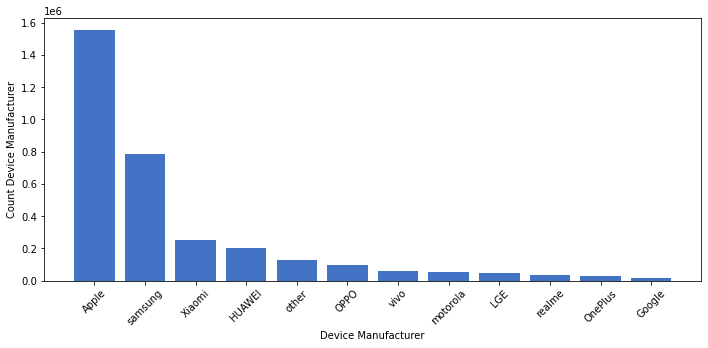

In [23]:
distribution_device_manufacturer = list(df["first_device_manufacturer"].value_counts())
device_manufacturer = df["first_device_manufacturer"].value_counts()

percentage = (device_manufacturer / len(df["first_device_manufacturer"])) * 100

considered = percentage[:10]
rest = percentage[11:]

print("We are only considering the 10 most common device manufacturer that represent %s%% of all device manufacturers." % (sum(considered)))

#replace all non considered manufacturer with other
df.loc[df['first_device_manufacturer'].isin(list(rest.index)), 'first_device_manufacturer'] = "other"


# Plot number of employees per month
plt.figure(figsize=(10, 5))
#Create the plots
plt.bar(df["first_device_manufacturer"].value_counts().index,list(df["first_device_manufacturer"].value_counts()), color = '#4472C4', label = 'Device Manufacturer')
#Create the title, axis description and legend
#plt.title('Histogram Device Manufacturer')
plt.ylabel('Count Device Manufacturer')
plt.xlabel("Device Manufacturer")
#plt.legend()
#plt.grid()
plt.xticks(rotation = 45)
plt.rcParams.update({'font.size': 12})
plt.tight_layout()
plt.savefig('results/cat_device.png')


#### Imputation of hardware features

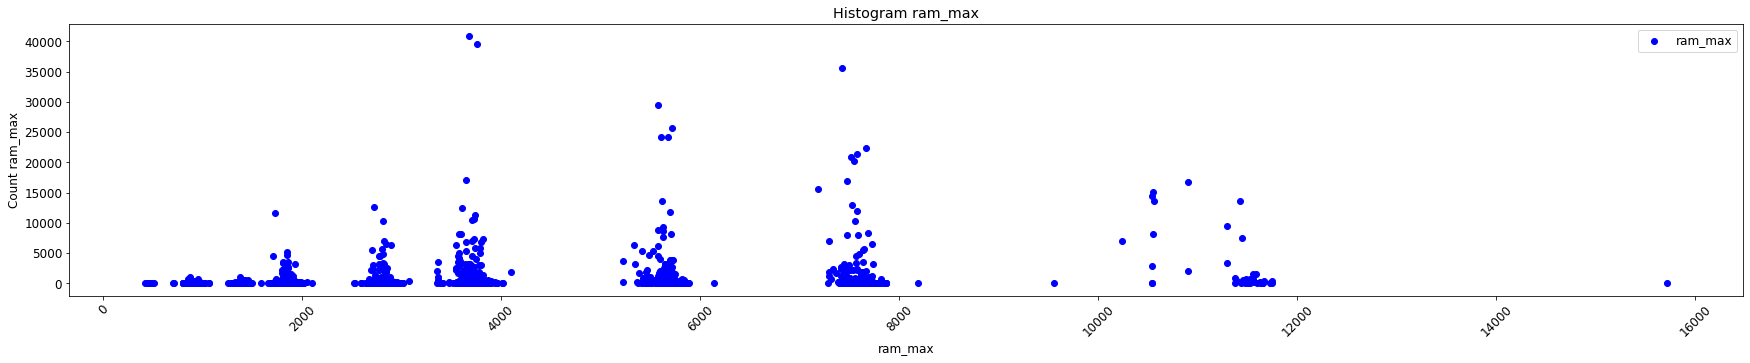

In [24]:
# Plot number of employees per month
plt.figure(figsize=(30, 5))
#Create the plots
plt.scatter(df["ram_max"].value_counts().index,list(df["ram_max"].value_counts()), color='blue', label = 'ram_max')
#Create the title, axis description and legend
plt.title('Histogram ram_max')
plt.ylabel('Count ram_max')
plt.xlabel("ram_max")
plt.legend()
plt.xticks(rotation = 45)
plt.rcParams.update({'font.size': 12})

#### Imputation of ram_max

In [25]:
# ram_max feature --> all Apple phones have NaNs --> impute with overall mean, 
# other NaNs impute with device manufacturer specific mean

ram_mean = df.groupby('first_device_manufacturer')['ram_max'].mean()
ram_mean['Apple'] = df['ram_max'].mean()
idx_nan_ram_max = df[df['ram_max'].isnull()].index.tolist()


df.loc[idx_nan_ram_max,'ram_max'] = df.loc[idx_nan_ram_max,'first_device_manufacturer'].apply(lambda x: ram_mean[x])

#### Imputation of first_network_type

In [26]:
# One or two values are 'null', drop those rows
df.drop(df[df["first_network_type"] == "null"].index, axis = 0, inplace = True)
# 2G only appears a few time -> change to Null
df["most_frequent_network_type"] = df["most_frequent_network_type"].apply(lambda x: "NULL" if x == '2G' else x)

#### Imputation of form_factor

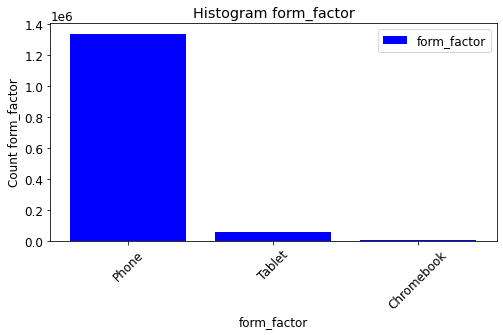

In [27]:
# Plot number of employees per month
plt.figure(figsize=(8, 4))
#Create the plots
plt.bar(df["form_factor"].value_counts().index,list(df["form_factor"].value_counts()), color='blue', label = 'form_factor')
#Create the title, axis description and legend
plt.title('Histogram form_factor')
plt.ylabel('Count form_factor')
plt.xlabel("form_factor")
plt.legend()
#plt.grid()
plt.xticks(rotation = 45)
plt.rcParams.update({'font.size': 12})

In [28]:
# Using information from device os to impute missing values for apple devices
df.loc[df['first_device_os'] == "iPadOS", 'form_factor'] = 'Tablet'
df.loc[df['first_device_os'] == "iOS", 'form_factor'] = 'Phone'

# Rest of NaNs are Phones according to the distribution
df['form_factor'] = df['form_factor'].fillna('Phone')

#### Imputation of screen_density

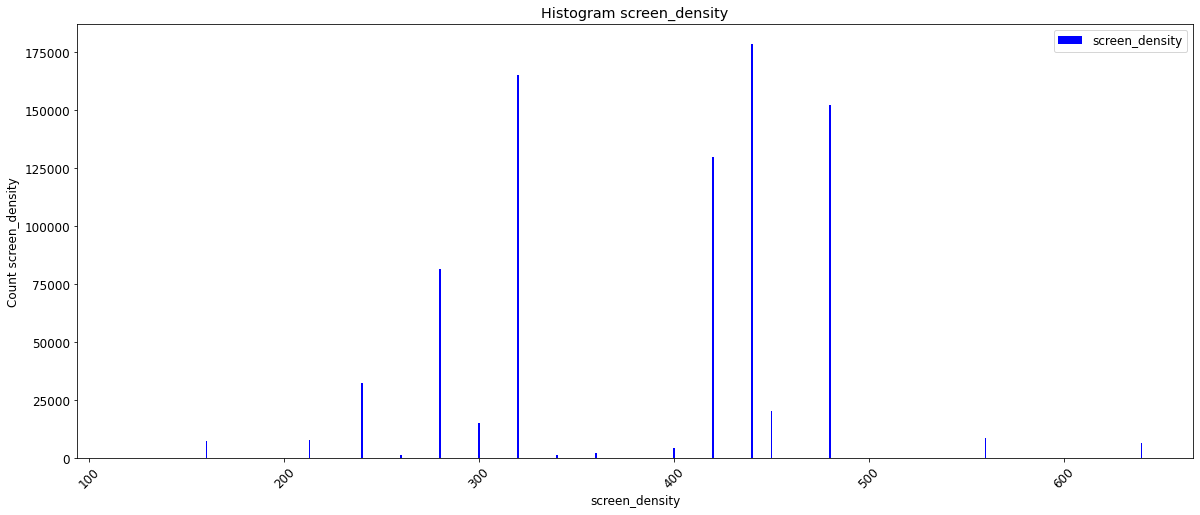

In [29]:
# screen_hight and screen_width have same NaNs. screen_density has NaNs, where screen_hight has NaNs 
# and 400k more NaNs

plt.figure(figsize=(20, 8))
#Create the plots
plt.bar(df["screen_density"].value_counts().index,list(df["screen_density"].value_counts()), color='blue', label = 'screen_density')
#Create the title, axis description and legend
plt.title('Histogram screen_density')
plt.ylabel('Count screen_density')
plt.xlabel("screen_density")
plt.legend()
#plt.grid()
plt.xticks(rotation = 45)
plt.rcParams.update({'font.size': 12})

In [30]:
# impute all screen_density with respective mean of their first_device_manufacturer, expect 'Apple' devices, since
# all screen_density are NaNs, impute with overall mean

screen_density_mean = df.groupby('first_device_manufacturer')['screen_density'].mean()
screen_density_mean['Apple'] = df['screen_density'].mean()
idx_nan_sd = df[df['screen_density'].isnull()].index.tolist()


df.loc[idx_nan_sd,'screen_density'] = df.loc[idx_nan_sd,'first_device_manufacturer'].apply(lambda x: screen_density_mean[x])

#### Imputation of screen_width

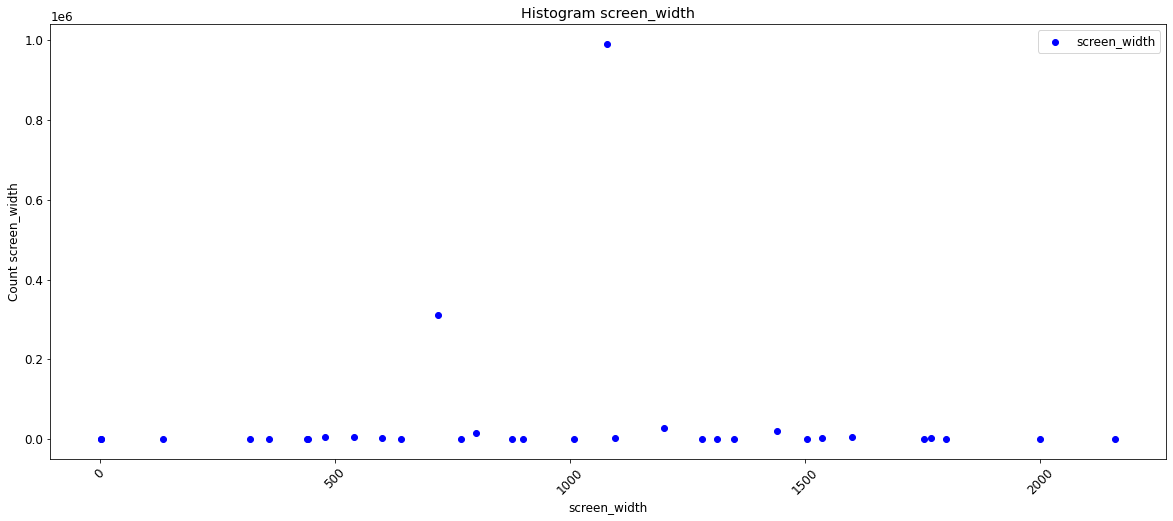

In [31]:
plt.figure(figsize=(20, 8))
#Create the plots
plt.scatter(df["screen_width"].value_counts().index,list(df["screen_width"].value_counts()), color='blue', label = 'screen_width')
#Create the title, axis description and legend
plt.title('Histogram screen_width')
plt.ylabel('Count screen_width')
plt.xlabel("screen_width")
plt.legend()
plt.xticks(rotation = 45)
plt.rcParams.update({'font.size': 12})

In [32]:
# impute all screen_width with respective mean of their first_device_manufacturer, expect 'Apple' devices, since
# all screen_width are NaNs, impute with overall mean

screen_width_mean = df.groupby('first_device_manufacturer')['screen_width'].mean()
screen_width_mean['Apple'] = df['screen_width'].mean()
idx_nan_sw = df[df['screen_width'].isnull()].index.tolist()


df.loc[idx_nan_sw,'screen_width'] = df.loc[idx_nan_sw,'first_device_manufacturer'].apply(lambda x: screen_width_mean[x])

#### Imputation of screen_height

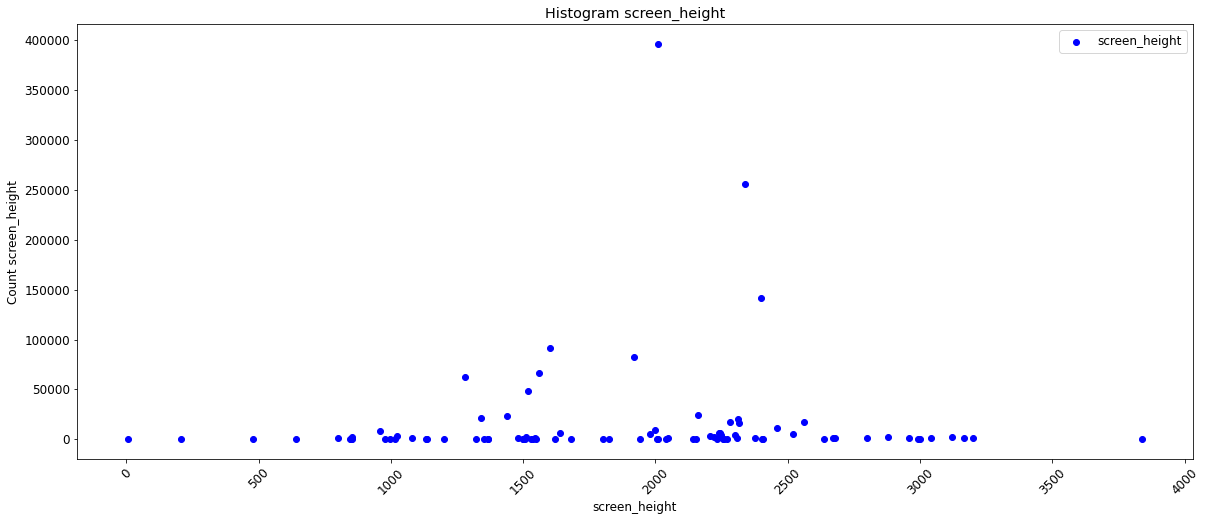

In [33]:
plt.figure(figsize=(20, 8))
#Create the plots
plt.scatter(df["screen_height"].value_counts().index,list(df["screen_height"].value_counts()), color='blue', label = 'screen_height')
#Create the title, axis description and legend
plt.title('Histogram screen_height')
plt.ylabel('Count screen_height')
plt.xlabel("screen_height")
plt.legend()
plt.xticks(rotation = 45)
plt.rcParams.update({'font.size': 12})

In [34]:
# impute all screen_height with respective mean of their first_device_manufacturer, expect 'Apple' devices, since
# all screen_height are NaNs, impute with overall mean

screen_height_mean = df.groupby('first_device_manufacturer')['screen_height'].mean()
screen_height_mean['Apple'] = df['screen_height'].mean()
idx_nan_sh = df[df['screen_height'].isnull()].index.tolist()

df.loc[idx_nan_sh,'screen_height'] = df.loc[idx_nan_sh,'first_device_manufacturer'].apply(lambda x: screen_height_mean[x])

In [35]:
# drop
df = df.drop(["first_device_os"], axis =1, errors = "ignore")

#### time_between_last_purchase_last_login

Normalize by 72h*60min*60s and set all NaNs to 1 (non buyers)

In [36]:
# normalize by 72h*60min*60s and set all NaNs to 1 (non buyers)
df['time_between_last_purchase_last_login'] = df['time_between_last_purchase_last_login'].apply(lambda x: 1 if math.isnan(x) else x / (72*60*60))

#### Clustering Device Language (add "other" column)

In [37]:
n = 14

print("Percentage fitting in the %s most frequent languages -->" %n, df['device_language'].value_counts()[:n].sum() / len(df))
print(df['device_language'].value_counts()[:n].index.tolist())

print(df['device_language'].value_counts()[n:].index.tolist())

other = df['device_language'].value_counts()[n:].index.tolist()

df['device_language'].loc[df['device_language'].isin(other)] = "other"


Percentage fitting in the 14 most frequent languages --> 0.9540438104039878
['en', 'fr', 'ru', 'de', 'ar', 'es', 'th', 'ko', 'tr', 'ja', 'pt', 'zh', 'pl', 'vi']
['nl', 'it', 'zh_TW', 'zh_CN', 'sv', 'nb', 'id', 'da', 'he', 'hu', 'ro', 'uk', 'fi', 'cs', 'el', 'hr', 'sk', 'ms', 'ars', 'ca', 'km', 'ckb', 'sr', 'sq', 'ka', 'bg', 'lt', 'pa', 'fa', 'gsw', 'yue', 'kk', 'cy', 'az', 'uz', 'hy', 'sm', 'to', 'my', 'et', 'mi', 'ks', 'lv', 'mn', 'so', 'ksh', 'is', 'bs', 'sco', 'af', 'nn', 'lo', 'ain', 'ga', 'fil', 'ht', 'gd', 'rm', 'dv', 'ur', 'sl', 'bo', 'kl', 'ta', 'se', 'ce', 'hsb', 'la', 'pap', 'fon', 'an', 'yo', 'fur', 'mk', 'rar', 'shn', 'am', 'wa', 'mni', 'os', 'ady', 'as', 'zgh', 'or', 'ig', 'awa', 'lkt', 'ug', 'ak', 'gor', 'xal', 'hz', 'bug', 'asa', 'alt', 'lus', 'war', 'jv', 'tlh', 'nv', 'si', 'xh', 'gu', 'srn', 'ti', 'kea', 'mic', 'eu']


#### Clustering Device Model (TODO, temporary drop)

In [38]:
df = df.drop(columns="first_device_model")

## Clustering (decreasing number of distincts)

#### Create World Map with User Statistics

In [39]:
# Create World Map of user login countries:
#function to get longitude and latitude data from country name
geolocator = Nominatim(user_agent='hans_peter@gmail.com')
def geolocate(country):
    try:
        # Geolocate the center of the country
        loc = geolocator.geocode(country)
        # And return latitude and longitude
        return (loc.latitude, loc.longitude)
    except:
        # Return missing value
        return np.nan

df_map = df["first_login_country"].apply(lambda x: (x,'NA') if x == 'SX' else (x,'AS') if x == 'TL' else 'EU' if x == 'VA' else (x,pc.country_alpha2_to_continent_code(x)))
df_map.reset_index(drop=True, inplace=True)

country_continent = pd.DataFrame(df_map.tolist())
frames = [df_map, country_continent]
result = pd.concat(frames, axis = 1)
result.rename(columns={'first_login_country':'first_login_country',0:'Country_Code', 1: 'Continent'}, inplace = True)

result['Country'] = result['Country_Code'].apply(lambda x: 'Kosovo' if x == 'XK' else 'Kosovo' if x == 'E' else pycountry.countries.get(alpha_2 = x).name)

frequency_country = (pd.DataFrame(result["Country_Code"].value_counts()) / len(result["Country_Code"])) * 100
frequency_country.rename(columns = {'Country_Code':'Frequency'}, inplace = True)
frequency_country.reset_index(inplace = True)
frequency_country.rename(columns = {'index':'Country_Code'}, inplace = True)

result_short = result.drop_duplicates(subset=['Country_Code'])
merged = pd.merge(result_short, frequency_country, how='inner', on='Country_Code')

coordinates = merged['Country'].apply(lambda x: geolocate(x))


In [40]:
# Update coordinates of Korea since geolocator places korea in russia
coordinates[merged['Country'][merged['Country'] == 'Korea, Republic of'].index[0]] = (35.9078, 127.7669)

In [41]:
locations = pd.DataFrame(coordinates)
locations.rename(columns={'Country':'Coordinates'}, inplace = True)

coordinates_x_y = pd.DataFrame(coordinates.tolist())
coordinates_x_y.rename(columns={0:'Latitude', 1: 'Longitude'}, inplace = True)
frames = [merged, locations, coordinates_x_y]
final_world = pd.concat(frames, axis = 1)
final_world.dropna(inplace = True)

In [42]:
# Create a world map to show distributions of users 
#empty map
world_map= folium.Map(tiles="cartodbpositron")
#marker_cluster = MarkerCluster().add_to(world_map)
#for each coordinate, create circlemarker of user percent
for i in range(len(final_world)):
        lat = final_world.iloc[i]['Latitude']
        long = final_world.iloc[i]['Longitude']
        radius = final_world.iloc[i]['Frequency']
        popup_text = """Country : {}<br>
                    %of Users : {}<br>"""
        popup_text = popup_text.format(final_world.iloc[i]['Country'],
                                   final_world.iloc[i]['Frequency']
                                   )
        folium.CircleMarker(location = [lat, long], radius=radius, popup= popup_text, fill =True).add_to(world_map)
        #folium.CircleMarker(location = [lat, long], radius=radius, popup= popup_text, fill =True).add_to(marker_cluster)
#show the map
world_map

#### Imputation of country features

#### Clustering country into continent

In [43]:
df["continent"] = df["first_login_country"].apply(lambda x: 'NA' if x == 'SX' else 'AS' if x == 'TL' else 'EU' if x == 'VA' else pc.country_alpha2_to_continent_code(x))
print("nunique: ", df["continent"].nunique())

bigmac_mean = df.groupby('continent')['bigmac_dollar_price'].mean()
gdp_mean = df.groupby('continent')['gdp_per_capita'].mean()

idx_nan_bigmac = df[df['bigmac_dollar_price'].isnull()].index.tolist()
idx_nan_gdp = df[df['gdp_per_capita'].isnull()].index.tolist()


df.loc[idx_nan_bigmac,'bigmac_dollar_price'] = df.loc[idx_nan_bigmac,'continent'].apply(lambda x: bigmac_mean[x])
df.loc[idx_nan_gdp,'gdp_per_capita'] = df.loc[idx_nan_gdp,'continent'].apply(lambda x: gdp_mean[x])

nunique:  6


We are only considering the 20 most common countries that represent 80.02714185289692% of all countries.


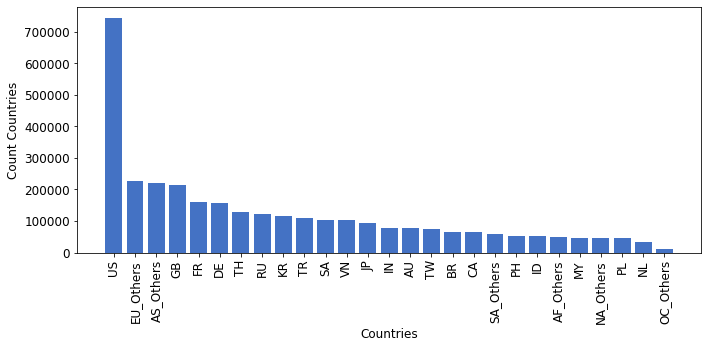

In [44]:
unique_countries = df["first_login_country"].value_counts()
percentage = (unique_countries / len(df["first_login_country"])) * 100

considered = percentage[:20]
rest = percentage[21:]

print("We are only considering the 20 most common countries that represent %s%% of all countries." % (sum(considered)))

#replace all non considered countries with their continent
df['first_login_country'] = df['first_login_country'].apply(lambda x: ('NA_Others' if x == 'SX' else 'AS_Others' if x == 'TL' else 'EU_Others' if x == 'VA' else str(pc.country_alpha2_to_continent_code(x)) + '_Others') if x in list(rest.index) else x)

#df.loc[df['first_login_country'].isin(list(rest.index)), 'first_login_country'] = "other"

# Plot number of employees per month
plt.figure(figsize=(10, 5))
#Create the plots
plt.bar(df["first_login_country"].value_counts().index,list(df["first_login_country"].value_counts()), color = '#4472C4', label = 'Countries')
#Create the title, axis description and legend
#plt.title('Histogram Countries')
plt.ylabel('Count Countries')
plt.xlabel("Countries")
plt.xticks(rotation = 90)
plt.rcParams.update({'font.size': 12})
plt.tight_layout()
plt.savefig('results/cat_language.png')

#### Clustering time-zones (based on train dataset)

In [45]:
# clustering time-zones 

train_timezone = df1_train["first_time_zone"]
test_timezone = df1_test["first_time_zone"]

# most occuring time-zone
max_occur = train_timezone.value_counts().sort_values(ascending = False).keys()[0]


# impute missing values
train_timezone[train_timezone.isnull()] = max_occur
test_timezone[test_timezone.isnull()] = max_occur

# building matching dict based on whole df1 (train+test)
df_timezone = train_timezone.append(test_timezone)


# creating a matching dict
time_zones = pd.DataFrame(df_timezone.value_counts())
time_zones.reset_index(inplace = True)

time_zones = time_zones.sort_values(by=['index'])
time_zones.reset_index(inplace = True)

limit = 70000
to_drop = time_zones[time_zones["first_time_zone"] <= limit].index.tolist()
to_remain = time_zones[time_zones["first_time_zone"] > limit].index.tolist()
to_drop_time = time_zones.iloc[to_drop]["index"].values

match = dict()

for index in range(len(time_zones)):
    
    if index in to_drop:

        if index > to_remain[-1]:
            last = to_remain[-1]
            time_zones["first_time_zone"].iloc[last] += time_zones["first_time_zone"].iloc[index]

            match[time_zones["index"].iloc[index]] = time_zones["index"].iloc[last]
            continue


        i_pre = next(to_remain[i-1] for i,x  in enumerate(to_remain) if x > index)
        time_zones["first_time_zone"].iloc[i_pre] += time_zones["first_time_zone"].iloc[index]
        match[time_zones["index"].iloc[index]] = time_zones["index"].iloc[i_pre]
        


#time_zones = time_zones.drop(to_drop)

print(match)

{'+03:30': '+03:00', '+04:00': '+03:00', '+04:30': '+03:00', '+05:00': '+03:00', '+05:45': '+05:30', '+06:00': '+05:30', '+06:30': '+05:30', '+08:30': '+08:00', '+08:45': '+08:00', '+09:30': '+09:00', '+10:00': '+09:00', '+10:30': '+09:00', '+11:00': '+09:00', '+12:00': '+09:00', '+12:45': '+09:00', '+13:00': '+09:00', '+14:00': '+09:00', '-01:00': '+09:00', '-02:00': '+09:00', '-03:30': '-03:00', '-04:30': '-04:00', '-08:00': '-07:00', '-09:00': '-07:00', '-09:30': '-07:00', '-10:00': '-07:00', '-11:00': '-07:00', '-12:00': '-07:00'}


In [46]:
# clustering the time-zone values in dataframe using the matching dict
df["first_time_zone"] = df["first_time_zone"].apply(lambda x: match[x] if x in to_drop_time else x )

print("nuniques", df["first_time_zone"].nunique())

nuniques 13


# Outlier

In [47]:
# seperating purchaser and non-purchaser
df_purchaser = df[df["sum_payments_package_key"] > 0 ]
df_non_purchaser = df[df["sum_payments_package_key"] == 0]

#### TODO: capping features should not be done for every numeric feature (problem e.g. at feature  "n_extra_challenge_buys" gets number of distinct values = 1 and therefore feature gets useless)

### Capping numerical features with 95% percentile --> seperating purchaser and non-purchaser

In [48]:
# numeric columns which should not be capped with 95% percentile (number of distinct values getting 1)

exceptions = ["n_friend_installs", "n_extra_challenge_buys", "n_friend_searches", "masked_feature_31"]

In [49]:
# just numerical columns (no categorical and no boolean)
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
columns_numerical = df.select_dtypes(include=numerics).drop(columns = exceptions, axis = 1).columns

limit_purchaser = df_purchaser[columns_numerical].quantile(.95)
limit_non_purchaser = df_non_purchaser[columns_numerical].quantile(.95)

In [50]:
temp = df['sum_payments_package_key_ltv'].copy()

for column in columns_numerical:
    df[column].loc[df_purchaser[df_purchaser[column] > limit_purchaser[column]].index] = int(limit_purchaser[column])
    df[column].loc[df_non_purchaser[df_non_purchaser[column] > limit_non_purchaser[column]].index] = int(limit_non_purchaser[column])

df['sum_payments_package_key_ltv_uncapped'] = temp


# CHECKING 

In [51]:
print("Columns containing NaN values: ",len(df.columns[df.isnull().any()]))
print("Columns with just 1 distinct/constant value: ",len(df.columns[df.nunique() == 1]))

Columns containing NaN values:  0
Columns with just 1 distinct/constant value:  1


In [52]:
df.isnull().sum().sort_values(ascending=False)[0:10]

n_ad_reward_claims                0
n_sessions_ended                  0
gdp_per_capita                    0
bigmac_dollar_price               0
n_viplevels_completed             0
n_time_skip_buys                  0
min_session_start_player_level    0
n_sessions_started                0
max_session_end_player_level      0
total_session_duration            0
dtype: int64

In [53]:
# catergorical features

cols = df.columns
num_cols = df._get_numeric_data().columns

cat_cols = list(set(cols) - set(num_cols))
df[cat_cols].nunique().sort_values(ascending=False)

first_login_country           27
device_language               15
first_time_zone               13
first_device_manufacturer     12
first_login_weekday            7
continent                      6
first_network_type             6
first_login_day_time           6
most_frequent_network_type     5
form_factor                    3
dtype: int64

### Save cleaned dataset as parqut

In [54]:
df.to_parquet('data/df1_clean.parquet')

Currently set clumpiness to zero when it is a no buyer.

In [55]:
df_2_123 = pd.read_parquet('data/df2_123.parquet', engine='pyarrow')
df_2_clump = pd.read_parquet('data/df2_clump_gradient.parquet', engine='pyarrow')

df_123_clump = df_2_123.join(df_2_clump, how = 'inner')

df_2_clean = df_123_clump.pipe(drop_col, ['frequency','event_time', 'amount', 'event_time_seconds','n_day_1','n_day_2','n_day_3'])
df_2_clean.reset_index(inplace = True)
df_2_clean.set_index('index', inplace=True)

target_index = df.index
source_index = df_2_clean.index

additional_index = list(set(target_index) - set(source_index))
source_remain = list(set(target_index) - set(additional_index))

df_2_remain = df_2_clean[df_2_clean.index.isin(source_remain)]

null_list = [0] * len(additional_index)

fill_rest_index = pd.Series(null_list, index = additional_index)

frame = { 'sum_day_1': fill_rest_index, 'sum_day_2': fill_rest_index, 'sum_day_3': fill_rest_index, 'clumpiness': fill_rest_index, 'gradient': fill_rest_index}

fill_rest = pd.DataFrame(frame)
fill_rest.index.name = 'account_id'

df_2 = df_2_remain.append(fill_rest)
df_2.index.name = 'account_id'
df_2

,sum_day_1,sum_day_2,sum_day_3,clumpiness,gradient
account_id,,,,,
100000423,9.99,0.00,0.0,0.229801,0.000000
100001374,0.00,2.99,0.0,0.035099,0.000000
100001463,0.99,0.00,0.0,0.860226,0.000000
100001654,6.99,0.00,0.0,0.839317,0.066611
100003092,0.99,0.00,0.0,0.858966,0.000000
...,...,...,...,...,...
124201414,0.00,0.00,0.0,0.000000,0.000000
95607133,0.00,0.00,0.0,0.000000,0.000000
120438652,0.00,0.00,0.0,0.000000,0.000000


In [56]:
merged = df.join(df_2, how = 'inner')
#merged = pd.concat([df, df_2_clean], axis=1)
merged.columns

Index(['n_ad_reward_claims', 'n_ad_reward_fails', 'n_ads_watched',
       'n_battlepass_lvls_finished', 'masked_feature_0', 'masked_feature_1',
       'masked_feature_2', 'masked_feature_3', 'masked_feature_4',
       'masked_feature_5', 'masked_feature_6', 'masked_feature_7',
       'masked_feature_8', 'masked_feature_13', 'masked_feature_14',
       'masked_feature_15', 'masked_feature_20', 'masked_feature_21',
       'masked_feature_22', 'masked_feature_23', 'masked_feature_24',
       'masked_feature_25', 'n_instant_awards_claims', 'masked_feature_27',
       'masked_feature_28', 'masked_feature_29', 'n_extra_challenge_buys',
       'connected_fb', 'connect_fb_attempt', 'n_friend_installs',
       'masked_feature_30', 'masked_feature_31', 'n_accept_all_friends',
       'n_accept_friend', 'n_clicked_add_friends', 'n_friend_searches',
       'masked_feature_32', 'masked_feature_35', 'masked_feature_36',
       'masked_feature_37', 'masked_feature_38', 'n_levels_completed',
       'de

In [57]:
# fix an issue with parquet:
merged.to_parquet("data/df_clean.parquet")
print("Data Preprocessing successful")

Data Preprocessing successful


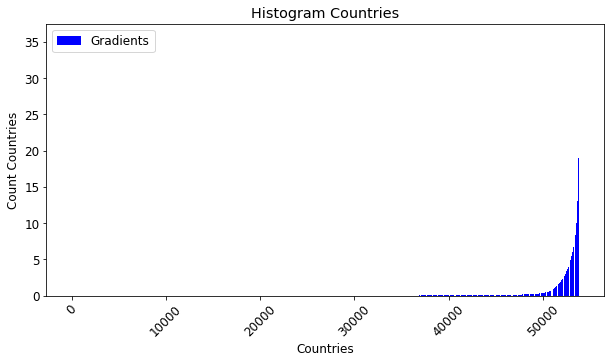

In [58]:
gradient = merged['gradient'].values
gradient.sort()
gradient = [i for i in gradient if i != 0]

for i in range(11):
    gradient.pop(-1)

plt.figure(figsize=(10, 5))
#Create the plots
plt.bar(range(1, len(gradient)+1),gradient, color='blue', label = 'Gradients')
plt.title('Histogram Countries')
plt.ylabel('Count Countries')
plt.xlabel("Countries")
plt.legend()
#plt.grid()
plt.xticks(rotation = 45)
plt.rcParams.update({'font.size': 12})


In [59]:

'sum_payments_package_key_ltv'

merged.train_test_split(df, test_size=0.15, random_state=42, shuffle=True, stratify=None)


AttributeError: 'DataFrame' object has no attribute 'train_test_split'

In [ ]:
# fix an issue with parquet:
merged.to_parquet("df_clean.parquet" %(data_name))
print("Data Preprocessing successful")

### Optional: Analyzing with Pandas Profiling

In [ ]:
#profile = ProfileReport(df, title="Dataset1 Train Cleaned Profiling")
#profile.to_file("dataset1_train_clean_%s_profiling.html" %(data_name)
#profile
                

# Data Reduction

In [ ]:
# intialize df
data_name = "train" # adapt for test dataset

#df = pd.read_pickle("df1_clean_%s.parquet" %(data_name))

df

## Feature Selection with correlation

### Feature Selection with correlation

#### Social Features

In [ ]:
df_corr = df.drop(columns =["n_payments_package_key_ltv","sum_payments_package_key_ltv"])
corr_matrix = df_corr.corr().abs()
corr_matrix.style.background_gradient(cmap='coolwarm')

In [ ]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


# Select columns with correlations above threshold
threshold = 0.95
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

#df = df.drop(columns = to_drop, errors='ignore')
print('There are %d columns to remove.' % (len(to_drop)))
print(to_drop)


In [ ]:
corr_matrix = upper[to_drop].corr().abs()
corr_matrix.style.background_gradient(cmap='coolwarm')


In [ ]:
import seaborn as sns

sns.heatmap(corr_matrix)

plt.savefig("Plotting_Correlation_HeatMap.jpg")

In [ ]:
social_features = ["connected_fb",
"connect_fb_attempt",
"n_friend_installs",
"masked_feature_30",
"masked_feature_31",
"n_accept_all_friends",
"n_accept_friend",
"n_clicked_add_friends",
"n_friend_searches",
"masked_feature_32",
"masked_feature_38"]

df_social = df[social_features]